In [1]:
import os
import cv2
import sys
import tqdm
import torch
import datetime
import torchvision

import numpy as np
import torch.nn as nn
import skimage.io as io
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from skimage import img_as_float
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Arguments

In [3]:
model_choice = 'fcn' # Select which model to train / test, can be 'fcn' or 'segnet'
weighted_choice = False # Select if loss function should be weighted or not
train = False # Select if you want to train or evaluate the model
img_size = 256

In [4]:
if not train:
    path_fcn_unweighted = './all_models/fcn/models/fcn_upsample_best.pth'
    path_segnet_unweighted = './all_models/segnet/models/segnet_upsample_best.pth'

In [5]:
np.random.seed(42)

# Models

Code for the models was taken from https://github.com/zijundeng/pytorch-semantic-segmentation

### FCN

In [6]:
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True)
        features, classifier = list(vgg.features.children()), list(vgg.classifier.children())

        features[0].padding = (100, 100)

        for f in features:
            if 'MaxPool' in f.__class__.__name__:
                f.ceil_mode = True
            elif 'ReLU' in f.__class__.__name__:
                f.inplace = True

        self.features3 = nn.Sequential(*features[: 17])
        self.features4 = nn.Sequential(*features[17: 24])
        self.features5 = nn.Sequential(*features[24:])

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)

        fc6 = nn.Conv2d(512, 4096, kernel_size=7)
        fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
        fc6.bias.data.copy_(classifier[0].bias.data)
        fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
        fc7.bias.data.copy_(classifier[3].bias.data)
        score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.score_fr = nn.Sequential(
            fc6, nn.ReLU(inplace=True), nn.Dropout(), fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr
        )

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, bias=False)

    def forward(self, x):
        x_size = x.size()
        pool3 = self.features3(x)
        pool4 = self.features4(pool3)
        pool5 = self.features5(pool4)

        score_fr = self.score_fr(pool5)
        upscore2 = self.upscore2(score_fr)

        score_pool4 = self.score_pool4(0.01 * pool4)
        upscore_pool4 = self.upscore_pool4(score_pool4[:, :, 5: (5 + upscore2.size()[2]), 5: (5 + upscore2.size()[3])]
                                           + upscore2)

        score_pool3 = self.score_pool3(0.0001 * pool3)
        upscore8 = self.upscore8(score_pool3[:, :, 9: (9 + upscore_pool4.size()[2]), 9: (9 + upscore_pool4.size()[3])]
                                 + upscore_pool4)
        return upscore8[:, :, 31: (31 + x_size[2]), 31: (31 + x_size[3])].contiguous()

### SegNet

In [7]:
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(_DecoderBlock, self).__init__()
        middle_channels = in_channels // 2
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)


class SegNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SegNet, self).__init__()
        vgg = torchvision.models.vgg19_bn(pretrained=True)
        features = list(vgg.features.children())
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:27])
        self.enc4 = nn.Sequential(*features[27:40])
        self.enc5 = nn.Sequential(*features[40:])

        self.dec5 = nn.Sequential(
            *([nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)] +
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)] * 4)
        )
        self.dec4 = _DecoderBlock(1024, 256, 4)
        self.dec3 = _DecoderBlock(512, 128, 4)
        self.dec2 = _DecoderBlock(256, 64, 2)
        self.dec1 = _DecoderBlock(128, num_classes, 2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec5 = self.dec5(enc5)
        dec4 = self.dec4(torch.cat([enc4, dec5], 1))
        dec3 = self.dec3(torch.cat([enc3, dec4], 1))
        dec2 = self.dec2(torch.cat([enc2, dec3], 1))
        dec1 = self.dec1(torch.cat([enc1, dec2], 1))
        return dec1

In [8]:
if model_choice == 'fcn':
    model = FCN8s(39).to(device)
else:
    model = SegNet(39).to(device)

# Dataloader

In [9]:
batch = 16

In [10]:
train_transforms = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, root, size, train=True, data_transforms=None):
        self.root = root
        if train:
            self.img_path = root + '/img/' + '/subset_train/'
            self.seg_path = root + '/seg/' + '/subset_train/'
        else:
            self.img_path = root + '/img/' + '/subset_val/'
            self.seg_path = root + '/seg/' + '/subset_val/'
        
        self.img_list, self.seg_list = os.listdir(self.img_path), os.listdir(self.seg_path)
        self.size = size
        self.data_transforms = data_transforms

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_list[index]))
        img = self.data_transforms(img)
        
        seg = cv2.resize(cv2.imread(os.path.join(self.seg_path, self.seg_list[index])), self.size, cv2.INTER_NEAREST)
        seg = torch.from_numpy(seg[:,:,0]).long()

        return img, seg

In [12]:
train_dataset = SegmentationDataset('./', (img_size,img_size), data_transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, num_workers=2, shuffle=True, batch_size=batch)

test_dataset = SegmentationDataset('./', (img_size,img_size), data_transforms=test_transforms, train=False)
test_dataloader = DataLoader(test_dataset, num_workers=2, shuffle=True, batch_size=1)

In [13]:
for i, data in enumerate(train_dataloader):
    print(data[0].shape, data[1].shape)
    print(np.unique(data[1].numpy()))
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


# Utilities

In [14]:
def checkAccuracy(pred, truth, batch_size):
    pred = pred.cpu().numpy()
    truth = truth.cpu().numpy()
    acc = np.count_nonzero(pred==truth) / (256*256*batch_size)
    return acc

def checkiou(pred, truth):
    intersection = pred & truth
    union = pred | truth
    iou = torch.mean((torch.sum(intersection).float()/torch.sum(union).float()).float()) 
    return iou

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def find_weights(dataset, num_classes):
    weights = np.ones((num_classes, 1))
    for i, data in enumerate(dataset):
        seg = data[1].numpy()
        cl, count = np.unique(seg, return_counts=True)
        for j in range(len(cl)):
            weights[cl[j]] += count[j]
    weights = weights / np.sum(weights)
    return np.reshape(np.reciprocal(weights), (weights.shape[0],1))

def checkclasswisedice(y_true, predicted, k=1):
    labels = np.unique(y_true)
    if k in labels:
        dice_score = 2.0 * np.sum(predicted[y_true==k]==k) / (np.sum(predicted[y_true==k]==k) + np.sum(y_true[y_true==k]==k))
        return dice_score, 1
    dice_score = 0.0
    return dice_score, 0

# Training

In [15]:
ROOT_DIR = './all_models/'
now = model_choice

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR + now):
    os.makedirs(ROOT_DIR + now)

LOG_DIR = ROOT_DIR + now + '/logs/' 
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

MODEL_DIR = ROOT_DIR + now + '/models/' 
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

summary_writer = SummaryWriter(LOG_DIR)

In [16]:
if weighted_choice:
    weights = torch.from_numpy(find_weights(train_dataset, 39)).float().to(device)
    criterion = nn.CrossEntropyLoss(weights).to(device)
else:
    criterion = nn.CrossEntropyLoss().to(device)
    
max_epoch = 50
optimizer = torch.optim.Adam(params=model.parameters(), lr=1.0e-3, betas=(0.9,0.999), weight_decay=1.0e-4)

In [17]:
if train:
    prev_score = 100
    for epoch in range(max_epoch):
        model.train()
        for i, data in enumerate(train_dataloader):
            img = data[0].float().to(device)
            seg = data[1].long().to(device)

            optimizer.zero_grad()

            output = model(img)
            loss = criterion(output, seg)
            loss.backward()

            optimizer.step()

            print('loss:{}'.format(loss.item()), "Epoch:{0} Batch:{1}/{2}".format(epoch, i, len(train_dataloader)))

            y = seg
            val = output.max(1)[1]

            test = torch.max(output.data, 1)[1]
            iou = checkiou(test, seg)

            print('Train IOU = {}'.format(iou))

            summary_writer.add_scalar("Train Loss", loss.item())
            summary_writer.add_scalar("Train IOU", iou)

        model.eval()
        scores = []
        for i, data in enumerate(test_dataloader):
            img = data[0].to(device).float()
            seg = data[1].to(device).long()

            output = model(img)
            loss = criterion(output, seg)

            y = seg.view(-1)
            val = output.max(1)[1].view(-1)
            test = torch.max(output.data, 1)[1]
            iou = checkiou(test, seg)

            scores.append(loss.item())

            print('VAL dice for IOU = {}'.format(iou))

            if i > 100:
                break

        scores = np.mean(scores)
        if scores < prev_score:
            torch.save(model.state_dict(), MODEL_DIR+'{}_upsample_best.pth'.format(model_choice))
        prev_score = scores
        if epoch % 5 == 0:
            torch.save(model.state_dict(), MODEL_DIR+'{}_{}_upsample.pth'.format(epoch, model_choice))

# Analysis

In [18]:
def eval_model(model, val_set):
    total_acc, total_iou = 0, 0
    total_count = len(val_set)
    print('Total number of samples in the evaluation set is ', len(val_set))

    val_loader = DataLoader(val_set, num_workers=2, shuffle=False, batch_size=1)

    model.eval()
    len_dataloader = len(val_loader)
    for i, data in enumerate(val_loader):
        imgs = data[0].float().to(device)
        labels = data[1].long().to(device)

        with torch.no_grad():
            out= model(imgs)

        out_labels = torch.argmax(out, dim=1)

        prediction = out_labels.cpu().numpy()
        truth = labels.cpu().numpy()
        acc = np.count_nonzero(prediction == truth) / (img_size*img_size)
        total_acc += acc
        
        iou = checkiou(out_labels, labels)
        total_iou += iou

    return total_acc / total_count, total_iou / total_count

In [21]:
def visualize(model, val_set):
    index = np.random.randint(len(val_set))
    data = val_set.__getitem__(0)
    imgs = data[0].unsqueeze(0).float().to(device)
    labels = data[1].unsqueeze(0).long().to(device)

    with torch.no_grad():
        out= model(imgs)

    out_labels = torch.argmax(out, dim=1)

    img = imgs[0,:,:,:].permute(1,2,0).detach().cpu().numpy()
    gt = labels[0,:,:].detach().cpu().numpy()
    pred = out_labels[0,:,:].detach().cpu().numpy()
    
    return img, gt, pred

### FCN Results

In [20]:
model = FCN8s(39).to(device)
model.load_state_dict(torch.load(path_fcn_unweighted))

<All keys matched successfully>

##### Quantitative Results

In [22]:
acc, iou = eval_model(model, test_dataset)

Total number of samples in the evaluation set is  100


In [23]:
print('Accuracy and IOU on the test set is {} and {}'.format(acc, iou))

Accuracy and IOU on the test set is 0.744622802734375 and 0.6023732423782349


##### Qualitative Results

In [24]:
img, gt, pred = visualize(model, test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


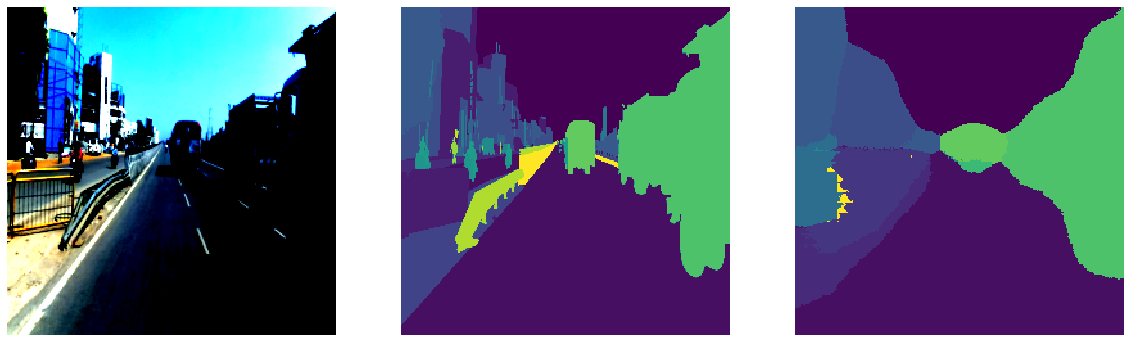

In [25]:
fig = plt.figure(figsize=(20,60))
ax_top_1 = fig.add_subplot(131)
ax_top_1.set_axis_off()
plt.imshow(img, label='Input')
ax_top_2 = fig.add_subplot(132)
ax_top_2.set_axis_off()
plt.imshow(gt, label='Ground truth')
ax_top_3 = fig.add_subplot(133)
ax_top_3.set_axis_off()
plt.imshow(pred, label='Output of FCN')
plt.show()
fig.savefig('./fcn.png', bbox_inches = 'tight', pad_inches = 0)

### SegNet Results

In [26]:
model = SegNet(39).to(device)
model.load_state_dict(torch.load(path_segnet_unweighted))

<All keys matched successfully>

##### Quantitative Results

In [27]:
acc, iou = eval_model(model, test_dataset)

Total number of samples in the evaluation set is  100


In [28]:
print('Accuracy and IOU on the test set is {} and {}'.format(acc, iou))

Accuracy and IOU on the test set is 0.791986083984375 and 0.6344586610794067


##### Qualitative Results

In [29]:
img, gt, pred = visualize(model, test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


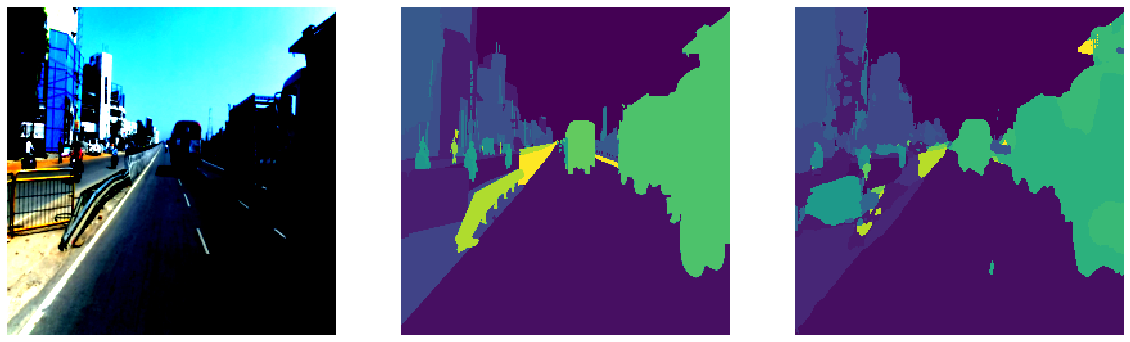

In [30]:
fig = plt.figure(figsize=(20,60))
ax_top_1 = fig.add_subplot(131)
ax_top_1.set_axis_off()
plt.imshow(img, label='Input MRI')
ax_top_2 = fig.add_subplot(132)
ax_top_2.set_axis_off()
plt.imshow(gt, label='Ground truth')
ax_top_3 = fig.add_subplot(133)
ax_top_3.set_axis_off()
plt.imshow(pred, label='Output of U-SegNet')
plt.show()
fig.savefig('./segnet.png', bbox_inches = 'tight', pad_inches = 0)